# Singapore Resale Flat Prices

The aim of this project is to analyze the resale flat prices in Singapore, and to build a model which is capable of accurately predicting resale flat prices in Singapore.

The data used in this project is available from: https://data.gov.sg/dataset/resale-flat-prices.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from lightgbm import LGBMRegressor

import time

import tqdm

import os

import pickle

import geopy

import warnings
warnings.filterwarnings("ignore")

## Part 1 - Annual Resale Trends

For the first part of this notebook, we will analyze all data points for 1990 - present. In particular, we want to find out how median prices have changed over time since 1990.

The consolidated data has the following columns: 

`['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']`.

In [2]:
# The raw data used in this script can be downloaded from my GitHub repository:
# https://github.com/natsunoyuki/Data_Science/tree/master/resale_flat_prices/raw_data

data_dir = "https://github.com/natsunoyuki/Data_Science/blob/master/resale_flat_prices/raw_data/"
data_file = "consolidated-resale-flat-prices.csv.zip?raw=true"

data = pd.read_csv(data_dir + data_file, compression = "zip")

print("Downloaded data shape:", data.shape)

display(data.head(3))

Downloaded data shape: (858136, 10)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price
0,2012-03,ANG MO KIO,2 ROOM,172,ANG MO KIO AVE 4,06 TO 10,45.0,Improved,1986,250000.0
1,2012-03,ANG MO KIO,2 ROOM,510,ANG MO KIO AVE 8,01 TO 05,44.0,Improved,1980,265000.0
2,2012-03,ANG MO KIO,3 ROOM,610,ANG MO KIO AVE 4,06 TO 10,68.0,New Generation,1980,315000.0


There are more than 800000 resales over a time span of about 30 years. This implies an average of 27000 resales per year! Also note that we should not use all data points to construct the model, as prices change from year to year and also because of inflation etc. Therefore we should perhaps take the data from the most recent years.

Also, the format of the data in the columns are not standardized, e.g. under flat_model we have `Improved` and `IMPROVED`, `New Generation` and `NEW GENERATION`. We will need to clean up the data and standardize the format of the raw data, and then perform encoding of the raw data to numerical form!

### Preprocessing `Month`

`month` contains both the year and month of resale. Extract the year and plot the number of resales per year.

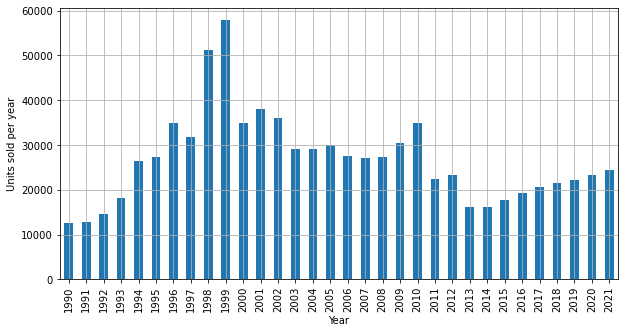

In [3]:
# Clean up the date format in the column month.

def month_formatter(x):
    # converts 2017-01 to 201701 int format
    return int(x[:4])*100 + int(x[5:])

def year_from_month(x):
    # converts 2017-01 to 2017 int format
    return int(x[:4])

def mth_from_month(x):
    # converts 2017-01 to 1 int format
    return int(x[5:])

# Extract the resale year, and check the distribution
data['year'] = data['month'].apply(year_from_month)

plt.figure(figsize = (10, 5))
data.value_counts('year').sort_index().plot(kind = "bar")
plt.xlabel('Year')
plt.ylabel('Units sold per year')
plt.grid('on')
plt.show()

It seems that majority of resales occur during just before 2000. We think that this is closely related to the 1997 Asian financial crisis which caused a recession in East Asia + South East Asia during 1997 - 1999. Perhaps this crisis forced some people to sell their flats for income? Surprisingly, there is not corresponding large peak during the Lehmann shock period of 2007 - 2009. Perhaps because no potential resale buyers were found due to the severe world wide recession? Also in particular, there is a low during 2013 ~ 2015... We are not too sure about any world wide or local events which correspond to this... 

Also, check if the month has any effect on the sales.

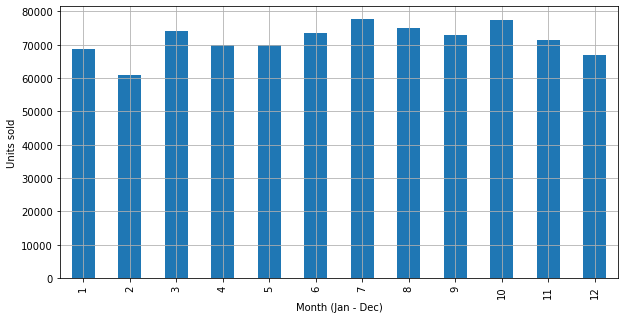

In [4]:
# Extract the resale month and check the distribution.

data['mth'] = data['month'].apply(mth_from_month)

plt.figure(figsize = (10, 5))
data.value_counts("mth").sort_index().plot(kind = "bar")
plt.xlabel('Month (Jan - Dec)')
plt.ylabel('Units sold')
plt.grid('on')
plt.show()

There does not seem to be a huge variation in the number of resale units throughout the 12 months! So the total resales are pretty constant throughout the year. Perhaps we should do this analysis year by year? But then this means that we will have 30 years to go through.

In [5]:
# Format the resale year and month to yyyymm integer format.

data['year_month'] = pd.to_datetime(data['month'])

We do not gain much new information from this time series, with the exception of the peak corresponding to the 1997 Asian financial crisis and a second small peak corresponding to the Lehmann shock. We guess that these peaks correspond to people selling their apartments for cash during economically hard times rather than there being a good market for apartments...

Also do a time series to track how the mean or median prices change over time? That might be a more educational indicator than the total number of resales as a time series!

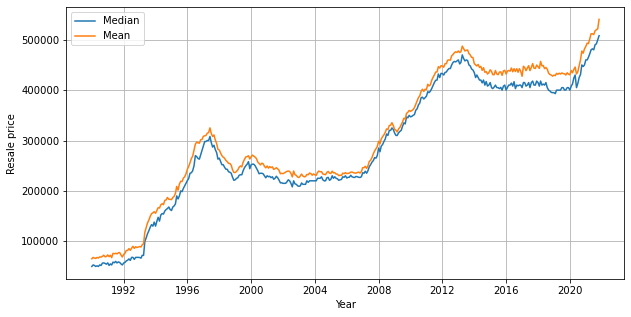

In [6]:
median_price = data[["year_month", "resale_price"]].groupby("year_month").median().reset_index()
median_price = median_price.sort_values('year_month')

mean_price = data[["year_month", "resale_price"]].groupby("year_month").mean().reset_index()
mean_price = mean_price.sort_values('year_month')

plt.figure(figsize = (10, 5))
plt.plot(median_price['year_month'], median_price['resale_price'])
plt.plot(mean_price['year_month'], mean_price['resale_price'])
plt.xlabel('Year')
plt.ylabel('Resale price')
plt.legend(["Median", "Mean"])
plt.grid('on')
plt.show()

The resale prices for the past are probably not adjusted for inflation, which should be taken into account when comparing past prices and current prices!

It appears that there are two local peaks... one peak corresponds to the 1997 Asian financial crisis and the dot-com bubble. Due to the 1997 Asian financial crisis we expected the resale prices to decrease especially with the sudden spike in the number of units resold (see graph above) leading to a sudden increase in the supply of flats. Perhaps the dot-com bubble had a stronger effect on the resale prices. The second peak corresponds to around 2012 - 2013 which is about half a decade after the Lehmann shock. We are not too familiar with the historical economic situation of Singapore, and would be very glad if someone could help us here!

## Part 2 - Data Cleaning

In this part we preprocess and clean up the rest of the features. We also restrict the data to the most recent data, as old data is not representative of the current state of the resale flat market.

In [7]:
print(data.columns)

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'year', 'mth', 'year_month'],
      dtype='object')


We have to deal with the following features: `town`, `flat_type`, `block`, `street_name`, `storey_range`, `floor_area_sqm`, `flat_model`, `least_commence_date` and the target: `resale_price`.

Also, as shown by the results above the resale prices can change very quickly from year to year. This means that only the most recent data should be used. We find that data from 2015 to 2019 is very stable with no major variations, followed by a sudden rise from 2020.

In [8]:
df = data[data["year"] >= 2015]

print(df.shape)

(149086, 13)


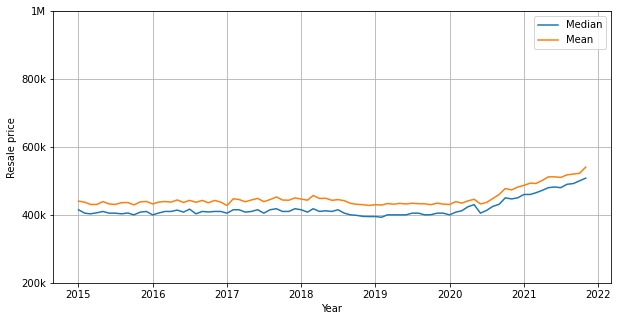

In [9]:
median_price = df[["year_month", "resale_price"]].groupby("year_month").median().reset_index()
median_price = median_price.sort_values('year_month')

mean_price = df[["year_month", "resale_price"]].groupby("year_month").mean().reset_index()
mean_price = mean_price.sort_values('year_month')

plt.figure(figsize = (10, 5))
plt.plot(median_price['year_month'], median_price['resale_price'])
plt.plot(mean_price['year_month'], mean_price['resale_price'])
plt.xlabel('Year')
plt.ylabel('Resale price')
plt.legend(["Median", "Mean"])
plt.grid('on')
plt.ylim([200000, 1000000])
plt.yticks(range(200000, 1200000, 200000), ["200k", "400k", "600k", "800k", "1M"])
plt.show()

There is an increase from SGD 400000 to more than SGD 500000 in the median resale prices. This means that the data from 2015 - 2020 is strictly speaking not suitable for use for predictions in 2021. We have to account for this temporal shift in the resale prices if we want an up-to-date model.

Also, if we restrict the time frame to a narrow period, we lose data points. On the other hand if we use slightly older data, the resale price is most likely going to be not updated enough.

### Preprocessing `town`

`town` contains the name of the town of the flat. 

In [10]:
print("Unique towns: {}.".format(len(df['town'].unique())))

Unique towns: 26.


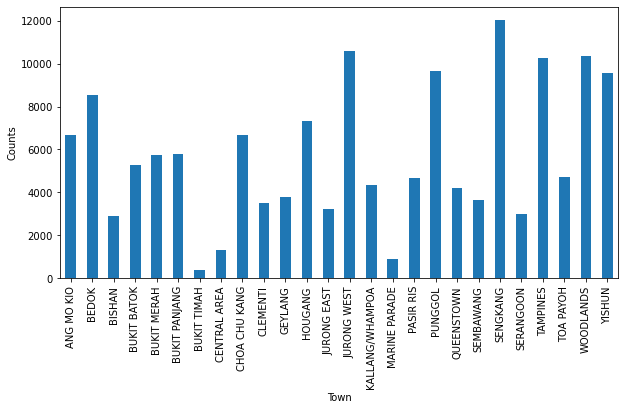

In [11]:
# Not all towns have the same counts...

plt.figure(figsize = (10, 5))
df['town'].value_counts().sort_index().plot(kind = "bar")
plt.xlabel("Town")
plt.ylabel("Counts")
plt.show()

While the median price across the board has increased very steadily, this might not be the case when looking at individual towns. Calculate the change in median price for each town.

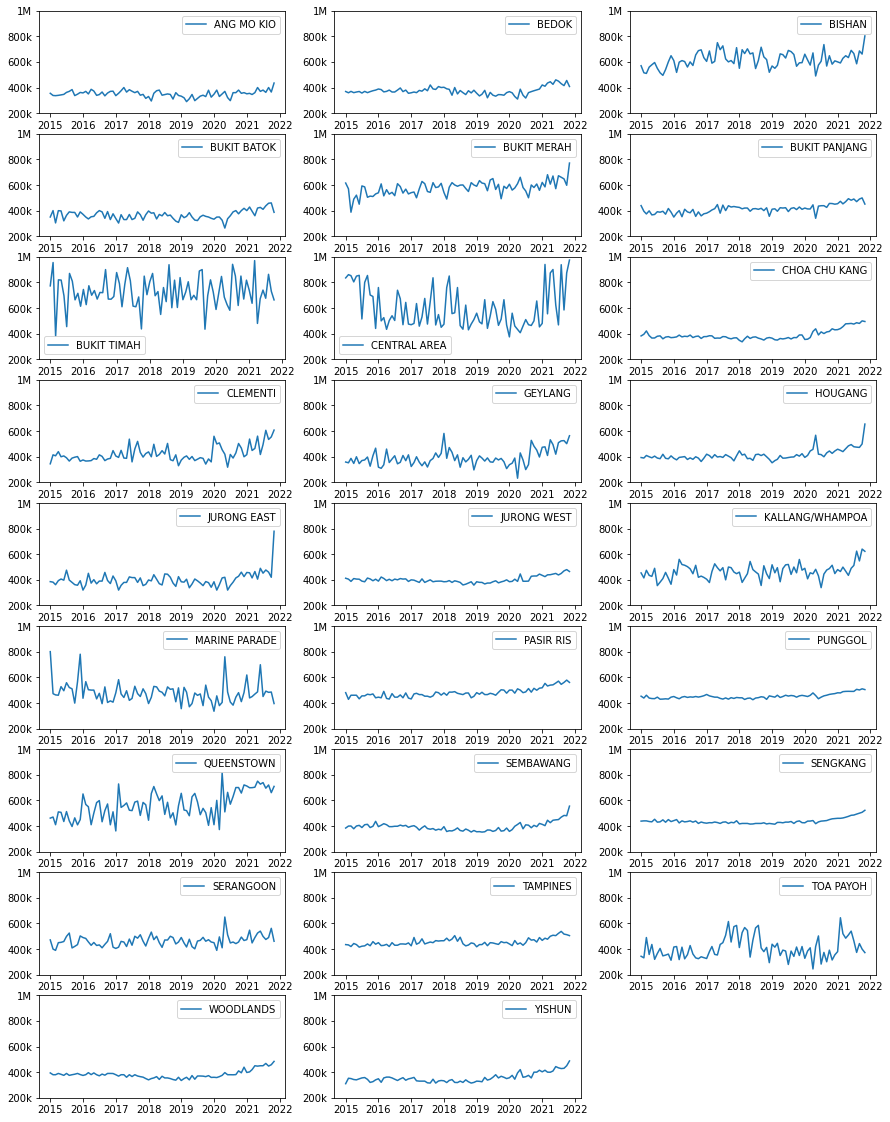

In [12]:
median_prices = df[["year_month", "resale_price", "town"]].groupby(["year_month", "town"]).median().reset_index()
median_prices = median_prices.sort_values('year_month')

towns = sorted(median_prices["town"].unique())

plt.figure(figsize = (15, 20))
for i, t in enumerate(towns):
    plt.subplot(int(np.round(len(towns)/3)), 3, i+1)
    want = median_prices[median_prices["town"] == t]
    plt.plot(want["year_month"], want["resale_price"])
    plt.legend([t])
    plt.ylim([200000, 1000000])
    plt.yticks(range(200000, 1200000, 200000), ["200k", "400k", "600k", "800k", "1M"])
plt.show()

#plt.figure(figsize = (15, 5))
#for t in sorted(median_price["town"].unique()):
#    want = median_price[median_price["town"] == t]
#    plt.plot(want["year_month"], want["resale_price"])
#plt.xlabel('Year')
#plt.ylabel('Resale price')
#plt.legend(sorted(median_price["town"].unique()))
#plt.grid('on')
#plt.show()

Not all towns are created equal. Some towns have seen an appreciation in prices, while others have not. Some towns have stable prices, while others have fluctuation prices.

We should account for the temporal drift in the resale prices. Perhaps one way to do this is to fit a simple regression model to model the increase in the median value of `resale_price` against time.

We break down the data according to their `town` values. For each `town`, we train a 4th order least squares linear regression model to model the temporal shift in the median value of `resale_price`. For now we skip splitting the data into train and test datasets due to the lack of data, although this should not be a problem due to the low order of the polynomials involved, and the relative smoothness in the changes in `resale_price`.

In [13]:
def least_squares(G, d):   
    m = np.dot(np.linalg.inv(np.dot(G.T, G)), G.T)
    m = np.dot(m, d)
    return m

def month_to_G(x, start_year = 2015):
    int_date = x.year * 100 + x.month
    year, month = np.divmod(int_date, 100)
    return (year - start_year) * 12 + month

def G_to_month(x, start_year = 2015):
    start_date = pd.to_datetime("{}-01-01".format(start_year))
    return start_date + pd.DateOffset(months = x - 1)

temporal_models = {}

for i in df["town"].unique():
    d = median_prices[median_prices["town"] == i]
    d["months"] = d["year_month"].apply(month_to_G)

    # From empirical studies, a 4th order Vander matrix appears to provide the best kernel.
    G = d["months"].values
    G = np.vander(G, 4)

    m = least_squares(G, d["resale_price"].values)
    
    temporal_models[i] = {}
    
    temporal_models[i]["model"] = m.copy()
    temporal_models[i]["G"] = G.copy()
    temporal_models[i]["d"] = d.copy()

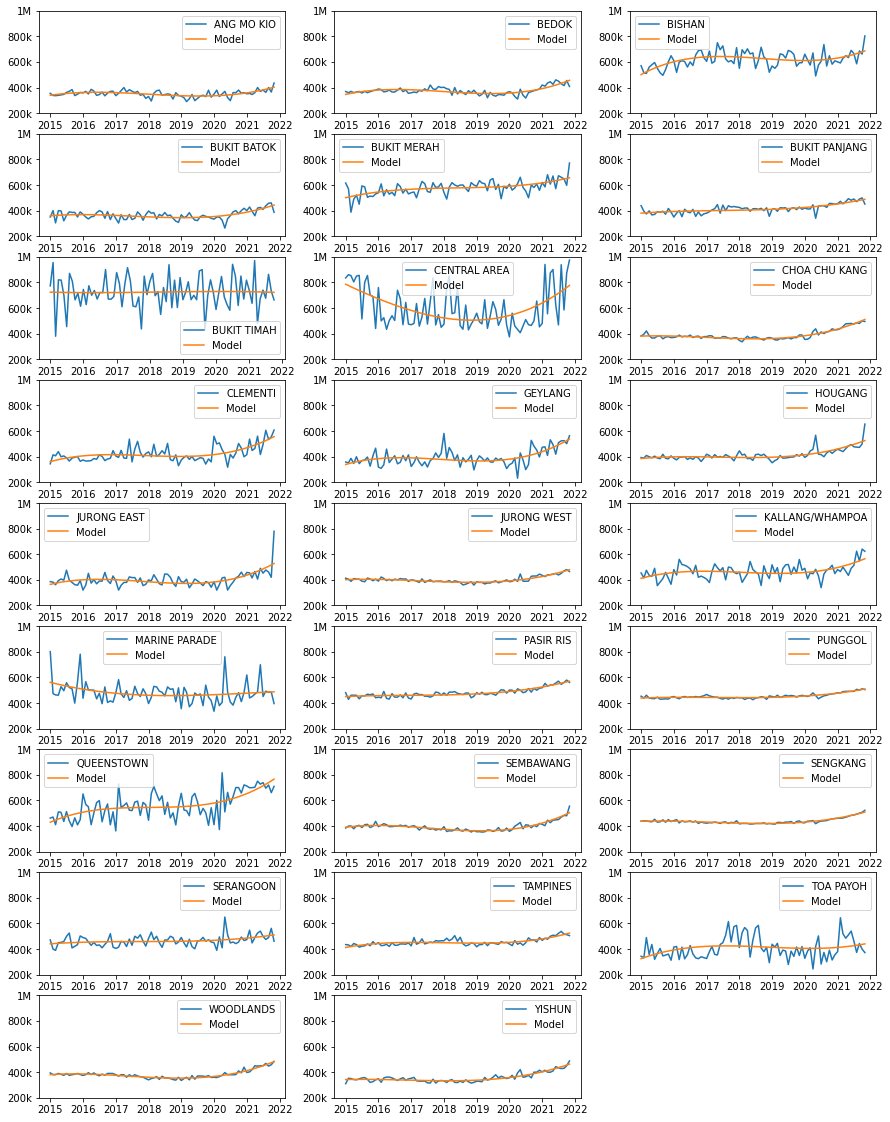

In [14]:
# Make predictions on the temporal shift in the resale price by the trained model.

plt.figure(figsize = (15, 20))
for i, t in enumerate(towns):
    plt.subplot(int(np.round(len(towns)/3)), 3, i+1)
    want = median_prices[median_prices["town"] == t]
    plt.plot(want["year_month"], want["resale_price"])
    m = temporal_models[t]["model"]
    d_pred = np.dot(temporal_models[t]["G"], m)
    plt.plot(want["year_month"], d_pred)
    plt.legend([t, "Model"])
    plt.ylim([200000, 1000000])
    plt.yticks(range(200000, 1200000, 200000), ["200k", "400k", "600k", "800k", "1M"])
plt.show()

Using the linear regression models, correct the past `resale_price` using a correction factor based on the latest prices, and store the adjusted `resale_price` in  `resale_price_adj`.

In [15]:
new_df = pd.DataFrame([])

for town_name in temporal_models:
    tmp_df = df[df["town"] == town_name]

    tmp_df["adj_months"] = tmp_df["year_month"].apply(month_to_G)

    start_index = np.dot(np.vander(tmp_df["adj_months"].values, 4), temporal_models[town_name]["model"])
    end_index = np.dot(np.vander([83], 4), temporal_models[town_name]["model"])

    tmp_df["adj_factor"] = end_index / start_index
    
    new_df = pd.concat([new_df, tmp_df])

df = new_df.copy()

In [16]:
df["resale_price_adj"] = df["resale_price"] * df["adj_factor"]
df["resale_price_adj"] = df["resale_price_adj"].astype(int)

display(df.head(3))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,mth,year_month,adj_months,adj_factor,resale_price_adj
339399,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,2017,1,2017-01-01,25,1.117602,259283
339400,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,250000.0,2017,1,2017-01-01,25,1.117602,279400
339401,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,262000.0,2017,1,2017-01-01,25,1.117602,292811


As `resale_price_adj` does not contain actual data, we will only use this column at the end for model training. For now, we continue our analysis using `resale_price`.

For each town, check the spread of the resale prices across the entire time frame. Unfortunately this means that the temporal drift is included in the plot.

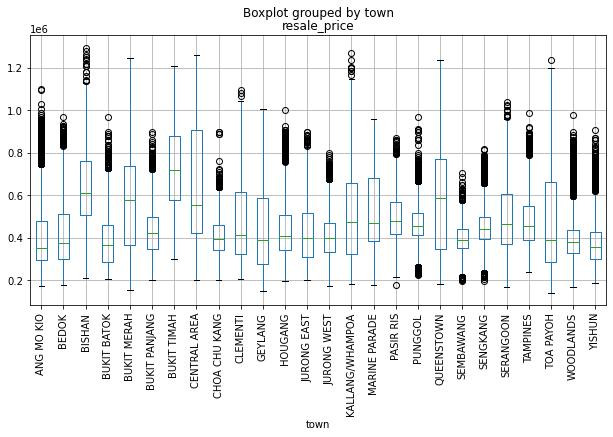

In [17]:
df[["town", "resale_price"]].boxplot(column = "resale_price", by = "town", rot = 90, figsize = (10, 5))
plt.show()

All the names are standardized to capital letters so we do not need to worry about the formatting. What we need to do is some sort of encoding to encode the town names numerically. We choose not to do one hot encoding as this will lead to a sudden increase in the number of cols.

Encode `town` numerically. The most straight forward method is to either use one-hot-encoding, or to assign each `town` value a numerical value. This can be some arbitrary value. Another method is to encode `town` by using the rank from the median resale price.

In [18]:
# Encode town by arbitrary numerical value

#town = {}
#for i,j in enumerate(sorted(df["town"].unique())):
#    town[j] = i
#print(town)
#df['town_num'] = df['town'].apply(lambda x: town[x]) 

In [19]:
# Or encode town by its rank according to the median resale price.

median_price_town = df[["resale_price", "town"]].groupby(["town"]).median().reset_index()
median_price_town = median_price_town.sort_values("resale_price")

median_price_town_rank = {}

for i in range(len(median_price_town)):
    median_price_town_rank[median_price_town.iloc[i]["town"]] = (i+1) / len(median_price_town)
    
df["town_rank"] = df["town"].apply(lambda x: median_price_town_rank[x])

display(df.head(1))

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,mth,year_month,adj_months,adj_factor,resale_price_adj,town_rank
339399,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,232000.0,2017,1,2017-01-01,25,1.117602,259283,0.038462


## Preprocessing `street_name`

`street_name` contains the name of the street of the flat.

In [20]:
# Check the format of street_name.

print("Total number of unique street names:", len(df['street_name'].unique()))

Total number of unique street names: 554


Surprisingly there are only about 600 unique street names. Singapore is a small country after all (728.6 km<sup>2</sup>), just a little larger than the 23 wards of Tokyo (627.6 km<sup>2</sup>).

Also, do a check in all the addresses for non-alphabetical characters, which might cause problems when performing geocoding.

In [21]:
problem_data = df['street_name'].apply(lambda x: True if "'" in x else False)
problem_data = df[problem_data]

print(np.shape(problem_data))
display(problem_data.head(3))

(1265, 17)


,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,year,mth,year_month,adj_months,adj_factor,resale_price_adj,town_rank
340826,2017-02,BUKIT TIMAH,3 ROOM,4,QUEEN'S RD,07 TO 09,74.0,Improved,1974,425000.0,2017,2,2017-02-01,26,1.001223,425519,1.0
345888,2017-05,BUKIT TIMAH,5 ROOM,1,QUEEN'S RD,22 TO 24,120.0,Standard,1974,915000.0,2017,5,2017-05-01,29,1.000393,915359,1.0
347796,2017-06,BUKIT TIMAH,3 ROOM,2,QUEEN'S RD,04 TO 06,74.0,Improved,1974,460000.0,2017,6,2017-06-01,30,1.000083,460038,1.0


In [22]:
street_name_list = sorted(df['street_name'].unique())

# Do a visual check just to be sure...

#print(sorted(street_name_list))

#for s in sorted(street_name_list):
#    print(s)

street_name_list_orig = street_name_list.copy()

We need to clean up the `street_name`. For example, C'WEALTH should be rendered as COMMONWEALTH. There might be other similar weird cases as well. There are also many short form words which should be cleaned up.

In [23]:
# For tidiness' sake, replace ALL short forms with the proper words

def street_name_cleaner(x):
    if "NTH" in x and "NORTH" not in x:
        x = x.replace("NTH", "NORTH")
    if "STH" in x and "SOUTH" not in x:
        x = x.replace("STH", "SOUTH")
    if "DR" in x and "DRIVE" not in x: 
        x = x.replace("DR", "DRIVE")
    if " RD" in x and "ROAD" not in x: 
        x = x.replace(" RD", " ROAD")
    if " ST" in x and "STREET" not in x: 
        x = x.replace(" ST", " STREET")
    if " AVE" in x and "AVENUE" not in x: 
        x = x.replace(" AVE", " AVENUE")
    if "CTRL" in x and "CENTRAL" not in x: 
        x = x.replace("CTRL", "CENTRAL")
    if "CRES" in x and "CRESCENT" not in x: 
        x = x.replace("CRES", "CRESCENT")
    if "PL " in x and "PLACE" not in x: 
        x = x.replace("PL ", "PLACE ")
    if " PL" in x and "PLAINS" not in x and "PLAZA" not in x: 
        x = x.replace(" PL", " PLACE")
    if "BT" in x and "BUKIT" not in x:
        x = x.replace("BT", "BUKIT")
    if "JLN" in x and "JALAN" not in x:
        x = x.replace("JLN", "JALAN")
    if "C'WEALTH" in x and "COMMONWEALTH" not in x:
        x = x.replace("C'WEALTH", "COMMONWEALTH")
    if " CL" in x and "CLOSE" not in x:
        x = x.replace("CL", "CLOSE")
    if "KG" in x and "KAMPONG" not in x:
        x = x.replace("KG", "KAMPONG")
    if "LOR " in x and "LORONG" not in x:
        x = x.replace("LOR ", "LORONG ")
    if "MKT" in x and "MARKET" not in x:
        x = x.replace("MKT", "MARKET")
    if "PK" in x and "PARK" not in x:
        x = x.replace("PK", "PARK")
    if "HTS" in x and "HEIGHTS" not in x:
        x = x.replace("HTS", "HEIGHTS")
    if "UPP " in x and "UPPER" not in x:
        x = x.replace("UPP", "UPPER")
    if "TG" in x and "TANJONG" not in x:
        x = x.replace("TG","TANJONG")
    if " TER" in x and "TERRACE" not in x: 
        x = x.replace("TER","TERRACE")
    if "GDNS" in x and "GARDENS" not in x: 
        x = x.replace("GDNS","GARDENS")
    return x

# Clean up the street names.
df['street_name_cleaned'] = df['street_name'].apply(street_name_cleaner)

for i in range(len(street_name_list)):
    street_name_list[i] = street_name_cleaner(street_name_list_orig[i])
    
#for s in range(len(street_name_list)):
#    print("{:32s}>>> {:32s}".format(street_name_list_orig[s], street_name_list[s]))

It is possible to geocode `street_name` using `geopy`, if one has enough resources to access paid geocoding web services. Instead of geocoding each sample, we perform geocoding using `street_name_list` to reduce resource usage. 

The `geopy` library provides access to multiple geocoding web services, some which are free and most which are not. The free services tend to have restrictions or limits to the usage, making it very difficult to geocode large amounts of data.

Geopy provides access to `Photon` which is free. Unfortunately this means that we are limited in the amount of data we can geocode. Also, the geocoding is not accurate at times. For example, `SINGAPORE, ANG MO KIO AVENUE 10` is geocoded as `Ren Ci@Ang Mo Kio, 10, Ang Mo Kio Avenue 8, 567727, Ang Mo Kio Avenue 8, Singapore, Singapore` which is not correct.

Another free service is `Nominatim`, which provides more accurate geocoding than `Photon`, but at the cost of more restrictions. `Nominatim` imposes a strict limit of a maximum 1 request per second.

In [24]:
def run_geocode(geocoder, street_name_list, random_sleep = False, sleep = None):
    geocoded_location = {}
    if random_sleep == False and sleep is None:
        sleep = 2

    for i in tqdm.trange(len(street_name_list)):
        address_to_geocode = "SINGAPORE, " + street_name_list[i]
        geocoded_address = geocoder.geocode(address_to_geocode)
        geocoded_location[address_to_geocode] = geocoded_address
        if random_sleep == True:
            sleep = np.random.random() * 2
            if sleep <= 1:
                sleep = sleep + 1
        time.sleep(sleep)
        
    return geocoded_location

In [25]:
#geocoder = geopy.geocoders.Nominatim(user_agent = "Singapore_addresses")
#geocoder = geopy.geocoders.Photon(user_agent = "Singapore_addresses")

#address_to_geocode = "BLK 406 ANG MO KIO AVENUE 10"
#geocoded_address = geocoder.geocode(address_to_geocode)
#print(geocoded_address)

#geocoded_street_names = run_geocode(geocoder, street_name_list[80:100], random_sleep = True)

In [26]:
#geocoded_locations = {**geocoded_locations, **geocoded_street_names}

#print(len(geocoded_locations))

Create a new feature `address` from `block` and `street name`. This provides more precise geographical information than just `street_name` or `town` alone.

In [27]:
df["address"] = df['block'] + " " + df['street_name_cleaned']
display(df.head(1)[["month", "town", "street_name", "street_name_cleaned", "block", "address", "resale_price"]])

,month,town,street_name,street_name_cleaned,block,address,resale_price
339399,2017-01,ANG MO KIO,ANG MO KIO AVE 10,ANG MO KIO AVENUE 10,406,406 ANG MO KIO AVENUE 10,232000.0


Check the total number of unique addresses. Remember that we only had 565 unique street names!

In [28]:
unique_addresses = sorted(df['address'].unique())

print("Total number of unique addresses:", len(unique_addresses))

Total number of unique addresses: 9205


That is a huge increase! `address` might be too localised to result in a good data set to use for the model, especially if the amount of data for a particular area is not large enough. `street_name` is more general and might give a better representation of the area.

One method to encode `address` numerically, is to sort the encoding by `street_name` so all similar street names will be close to each other numerically. If the addresses were sorted normally, the addresses would be sorted by `block` and block numbers close to each other would be close to each other numerically which would not make sense. However, such encoding is very simplistic and is not the best way to numerically encode addresses.

In [29]:
# Encode the addresses numerically.

#tmp = data[["street_name", "block"]]
#tmp = tmp.sort_values(["street_name", "block"])
#tmp['address'] = tmp['street_name'] + "/" + tmp['block'] 

#unique_addresses = sorted(tmp["address"].unique())

#addresses = {}

#for i,j in enumerate(unique_addresses):
    # The trick below is to allow me to sort the encoding by street name
    # so all similar street names will be close to each other numerically
    # If the addresses were sorted normally, the addresses would be sorted
    # by block and block numbers close to each other would be close to each
    # other numerically which would not make sense...
#    address_to_encode = j.split('/')[1] + " " + j.split('/')[0]
    #print(address_to_encode)
#    addresses[address_to_encode] = i

# Make a reverse dictionary?
    
#data['address_num'] = data['address'].apply(lambda x: addresses[x]) 
#display(data[['address', 'address_num']].head())

In [30]:
# Encode the street name numerically.
#street_names = {}

#for i,j in enumerate(sorted(data['street_name'].unique())):
#    street_names[j] = i
    
#data["street_name_num"] = data['street_name'].apply(lambda x: street_names[x])
#display(data[['street_name', 'street_name_num']].head())

For the time being, we will simply use `town` instead of `street_num` or `address` in order to reduce our computational cost. Geocoding is an expensive operation, and other simpler numerical encoding methods might lead to unexpected results.

## Preprocessing `flat_type`

`flat_type` contains information about the type of the flat.

In [31]:
display(data['flat_type'].value_counts())

4 ROOM              322597
3 ROOM              279368
5 ROOM              178919
EXECUTIVE            65166
2 ROOM               10281
1 ROOM                1284
MULTI GENERATION       279
MULTI-GENERATION       242
Name: flat_type, dtype: int64

The standardization is more or less good enough with the exception of MULTI GENERATION and MULTI-GENERATION, so we have to take that into account during the encoding. We do not use one hot encoding, and numerically encode to integers instead to prevent the number of columns from increasing too much!

Encode the flat type using numerical integers. In particular, we use a linear scale for the encoding to represent the value of the flat.

In [32]:
def flat_type_formatter(x):
    if x == '1 ROOM':
        res = 1/7
    elif x == '2 ROOM':
        res = 2/7
    elif x == '3 ROOM':
        res = 3/7
    elif x == '4 ROOM':
        res = 4/7
    elif x == '5 ROOM':
        res = 5/7
    elif x == 'EXECUTIVE':
        res = 6/7
    elif x == 'MULTI-GENERATION' or x == "MULTI GENERATION":
        res = 7/7
    else:
        res = -999999 #error value
    return res
    
df['flat_type_num'] = df['flat_type'].apply(flat_type_formatter)

display(df[['flat_type', 'flat_type_num']].head(3))

,flat_type,flat_type_num
339399,2 ROOM,0.285714
339400,3 ROOM,0.428571
339401,3 ROOM,0.428571


## Preprocessing `storey_range`

`storey_range` contains information about which floor the apartment is located on. Unfortunately, the exact floor is not made public.

In [33]:
print(df['storey_range'].value_counts().sort_index())

01 TO 03    27010
04 TO 06    34873
07 TO 09    31604
10 TO 12    27940
13 TO 15    13866
16 TO 18     6259
19 TO 21     2643
22 TO 24     1955
25 TO 27     1073
28 TO 30      676
31 TO 33      331
34 TO 36      316
37 TO 39      304
40 TO 42      151
43 TO 45       39
46 TO 48       34
49 TO 51       12
Name: storey_range, dtype: int64


The column storey_range is in a format which cannot be used  directly in the modelling, e.g. `04 TO 06`. We split the storeys into groups of 3 floors: 1-3, 4-6... Also, the highest floor across all flats in Singapore is 50. We can use this to scale the magnitude of the data properly.

In [34]:
# This encoding will allow us to use the storey_range directly in the model.

def storey_range_formatter(x, max_storey = 50):
    lower_storey = int(x[:2])
    upper_storey = int(x[-2:])
    group = (lower_storey + upper_storey) / 2
    return group / max_storey
    
df['storey_range_num'] = df['storey_range'].apply(storey_range_formatter)
display(df[['storey_range', 'storey_range_num']].head())

,storey_range,storey_range_num
339399,10 TO 12,0.22
339400,01 TO 03,0.04
339401,01 TO 03,0.04
339402,04 TO 06,0.10
339403,01 TO 03,0.04


## Preprocessing `flat_model`

`flat_model` contains information about the flat model. This is different from `flat_type`. Also, I have absolutely no idea what many of the `flat_model` values mean.

In [35]:
display(df['flat_model'].value_counts())

Model A                   47872
Improved                  37567
New Generation            20850
Premium Apartment         16287
Simplified                 6285
Apartment                  5912
Maisonette                 4412
Standard                   4359
DBSS                       2324
Model A2                   1905
Type S1                     337
Model A-Maisonette          269
Adjoined flat               258
Type S2                     168
Terrace                      95
Premium Apartment Loft       77
Multi Generation             61
Improved-Maisonette          22
2-room                       13
Premium Maisonette           13
Name: flat_model, dtype: int64

The data inside this column is a huge mess with some entries in all capital letters e.g. `New Generation` and `NEW GENERATION`. Also, we are not familiar with how flats and apartments are classified in Singapore, e.g. what is the difference between `Model A` and `Model A2`, or `Premium Maisonette` and `Improved-Maisonette`. We could definitely use some help here from someone who knows well about flats in Singapore!

In [36]:
# Convert everything into all capital letters
df['flat_model'] = df['flat_model'].apply(lambda x: x.upper())

print(df['flat_model'].value_counts().sort_index())

2-ROOM                       13
ADJOINED FLAT               258
APARTMENT                  5912
DBSS                       2324
IMPROVED                  37567
IMPROVED-MAISONETTE          22
MAISONETTE                 4412
MODEL A                   47872
MODEL A-MAISONETTE          269
MODEL A2                   1905
MULTI GENERATION             61
NEW GENERATION            20850
PREMIUM APARTMENT         16287
PREMIUM APARTMENT LOFT       77
PREMIUM MAISONETTE           13
SIMPLIFIED                 6285
STANDARD                   4359
TERRACE                      95
TYPE S1                     337
TYPE S2                     168
Name: flat_model, dtype: int64


This has helped to clean up the data. There are still many types which we am not familiar with, but we will not remove any types from now and simply use all the data.

We can use numerical encoding again to encode the flat models, although this is not a good idea as the resulting encoding is extremely arbitrary. 

In [37]:
#x = data['flat_model'].value_counts()
#print(x)

#flat_model = {}
#for i,j in enumerate(x.index):
#    flat_model[j] = i*10

#data['flat_model_num'] = data['flat_model'].apply(lambda x: flat_model[x])

#displaynatsumey(data[['flat_model', 'flat_model_num']].head())

## Preprocessing `floor_area_sqm`

`floor_area_sqm` contains information about the size of the flat.

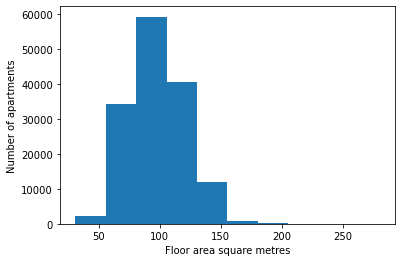

In [38]:
plt.hist(df['floor_area_sqm'])
plt.xlabel("Floor area square metres")
plt.ylabel("Number of apartments")
plt.show()

`floor_area_sqm` is right skewed and has a large range. Scale to [0, 1], and use np.log10 to correct the skew.

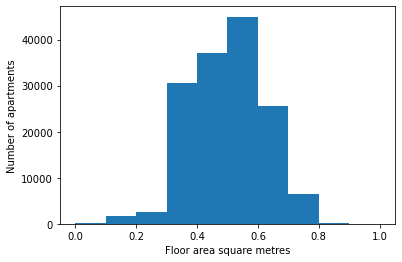

In [39]:
min_floor_area = df["floor_area_sqm"].min()
max_floor_area = df["floor_area_sqm"].max()

def floor_area_scaler(x, xmin, xmax):
    return (np.log10(x) - np.log10(xmin)) / (np.log10(xmax) - np.log10(xmin))

df["floor_area_norm"] = df["floor_area_sqm"].apply(floor_area_scaler, 
                                                         args = (min_floor_area, max_floor_area))

plt.hist(df['floor_area_norm'])
plt.xlabel("Floor area square metres")
plt.ylabel("Number of apartments")
plt.show()

## Preprocessing `lease_commence_date`

`lease_commence_date` is the start of the lease. In Singapore, flats have a lease of 99 years, after which they are destroyed and removed to give way for newer developments.

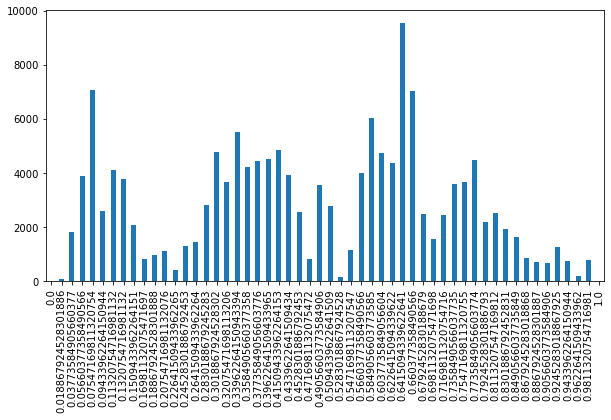

In [40]:
current_year = 2021

df["age"] = current_year - df["lease_commence_date"]

# Scale the age to [0, 1]
min_age = df["age"].min()
max_age = df["age"].max()

def age_scaler(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

df["age"] = df["age"].apply(age_scaler, args = (min_age, max_age))

df["age"].value_counts().sort_index().plot(kind = "bar", figsize = (10, 5))
plt.show()

## Part 3 - Preparation for Modelling

Specify the features to use in the modelling process!

1. Geographical information

`town`, `street_name` and `address` are all describing location at different scales. `town` is the least precise, followed by `street_name` and `address` is the most precise. Note that `address` contains information from `street_name`. The problem with using `address` is that some addresses are very rare and do not contribute much to the model. Also, if geocoding has not been carried out successfully then `address` becomes difficult to use. 

We use `town_rank` for the geographical information for the time being.

2. Building information

We use `flat_type_num`, `storey_range_num`, `floor_area_sqm` and `age`. 

From conventional knowledge, ground floor apartments tend to be cheaper than those on higher floors, larger flats tend to be more expensive than small ones, and new flats should be more expensive than old ones due to aging infrastructure.

We exclude `flat_model_num` as most buyers/sellers are unlikely to be able to tell the difference between the various different models `[MODEL A, IMPROVED, NEW GENERATION...]`.

3. Target

We can either use `resale_price` or `resale_price_adj` for the target. `resale_price` is the real world data, but contains temporal shifts which means that the older data is outdated. `resale_price_adj` contains the adjusted values of `resale_price`, but is not actual data.

For the time being, we use `resale_price_adj` to train the model in order to account for the temporal shifts in `resale_price`. 

In [41]:
features = ['town_rank', 'flat_type_num', 'storey_range_num', 'floor_area_norm', "age"]

target = 'resale_price_adj'

# For modelling we will not touch data directly but rely on X and y!
X = df[features]

print("Feature matrix shape:",np.shape(X))

Feature matrix shape: (149086, 5)


In [42]:
display(X.head(3))

,town_rank,flat_type_num,storey_range_num,floor_area_norm,age
339399,0.038462,0.285714,0.22,0.159125,0.754717
339400,0.038462,0.428571,0.04,0.350193,0.773585
339401,0.038462,0.428571,0.04,0.350193,0.735849


## Scaling the Data Distribution for Model Training

Check the distribution of the resale flat prices!

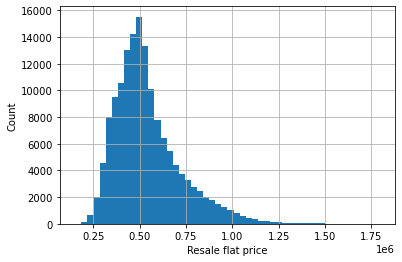

In [43]:
y = df[target]

plt.hist(y, 50)
plt.xlabel("Resale flat price")
plt.ylabel("Count")
plt.grid(True)
plt.show()

The distribution is skewed to the right, which make sense. Usually there are many "cheap" aparments and a few "expensive" ones.

In general, for regression models, the target should follow a Gaussian distribution for best performance. Therefore we should apply a `log` function to the target variable!

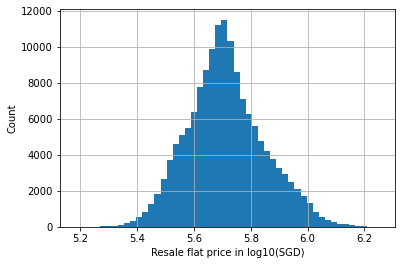

In [44]:
# Perform corrections to the resale price distribution by applying a log function to y:

def y_scaler(x):
    return np.log10(x)

def y_descaler(y):
    return 10**y

y = df[target].apply(y_scaler)

plt.hist(y, 50)
plt.xlabel("Resale flat price in log10(SGD)")
plt.ylabel("Count")
plt.grid(True)
plt.show()

The log price is certainly more normally distributed than the non-log price!

## Part 4 - Model Training

In this part, we train a model to predict the resale flat prices using the cleaned data from above.

As we only have 5 different features, and we expect some amount of non-linearity in the features, we use decision tree based methods here. In particular, we use a gradient boosted machine model which is able to adapt learn from its own mistakes during the training process, making it more powerful than random forests.

First of all, split the data into training and test sets in order to verify that the model's output is generalizable, and that the model is not overfitting to the training data.

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

print(np.shape(X_train),np.shape(X_test),np.shape(y_train),np.shape(y_test))

(111814, 5) (37272, 5) (111814,) (37272,)


We use the gradient boosting machine library `lightgbm` to create our resale price model. <a href="https://en.wikipedia.org/wiki/Gradient_boosting" target="_blank">Gradient boosting models</a> are <a href="https://en.wikipedia.org/wiki/Decision_tree" target="_blank">decision tree</a> based models, similar to <a href="https://en.wikipedia.org/wiki/Random_forest" target="_blank">random forest models</a>. The main feature of gradient boosting models is that the individual decision trees are trained sequentially. The first tree is trained on the target, and the second tree is trained on the error between the first tree's predictions and the target, and the third tree is trained on the second tree's error and so on. This mistake correcting feature allows us to train relatively powerful models without using large amounts of computing resources.

We perform a cross validation grid search on `X_train` and `y_train`. When training a model, <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)" target="_blank">cross validation</a> as well as a <a href="https://en.wikipedia.org/wiki/Hyperparameter_optimization" target="_blank">hyperparameter search</a> should be conducted in order to optimize the model's performance and generalization. The cross validation here occurs only on one set of `X_train` and `y_train`, which might not be suitable for certain datasets. To conduct cross validation grid search, <a href="https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html" target="_blank">nested cross validation</a> should be used on the entire dataset

Cross validation evaluates the generalization performance of a model that is more stable than simply using a single test set. We combine cross validation with a hyperparameter grid search using `GridSearchCV` from `sklearn`. We perform the grid search for the number of decision trees used in the model `n_estimators`. For now the search is performed from 100 to 500 estimators due to limitations in computational resources. Also, if possible, a more thorough grid search involving other hyperparamters such as `num_leaves` or `max_depth` or `learning_rate` should be carried out as gradient boosting models are sensitive to hyperparameter values.

We use the <a href="https://en.wikipedia.org/wiki/Huber_loss" target="_blank">Huber loss</a> as the objective function, which is less sensitive to outliers than the <a href="https://en.wikipedia.org/wiki/Mean_squared_error" target="_blank">mean squared error</a>. 

In order to measure the performance of the trained model, we use the mean absolute error, the mean squared error and the coefficient of determination.

In [46]:
param_grid = {"n_estimators" : [100, 200, 300, 400, 500]}

grid_search = GridSearchCV(LGBMRegressor(num_leaves = 2 ** 5, max_depth = 5, 
                                         objective = "huber", random_state = 0),
                                         param_grid = param_grid, cv = 5)

start_time = time.time()
grid_search.fit(X_train, y_train)
print("Time elapsed: {:.3f}s.".format(time.time() - start_time))

Time elapsed: 18.616s.


In [47]:
print("Train CV score:  {:.3f}.".format(grid_search.best_score_))

Train CV score:  0.917.


In [48]:
print("Best hyper parameters: {}.".format(grid_search.best_params_))

Best hyper parameters: {'n_estimators': 500}.


In [49]:
print("Best performing model: {}.".format(grid_search.best_estimator_))

Best performing model: LGBMRegressor(max_depth=5, n_estimators=500, num_leaves=32, objective='huber',
              random_state=0).


In [50]:
# Use the best_estimator_ as the prediction model.
model = grid_search.best_estimator_

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
print("Train mae: {:.3f}, test mae: {:.3f}.".format(train_mae, test_mae))

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
print("Train mse: {:.3f}, test mse: {:.3f}.".format(train_mse, test_mse))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print("Test R2:   {:.3f}, test R2:  {:.3f}.".format(train_r2, test_r2))

Train mae: 0.029, test mae: 0.029.
Train mse: 0.001, test mse: 0.002.
Test R2:   0.921, test R2:  0.918.


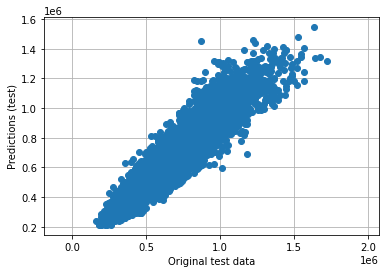

In [51]:
# As the resale price has been scaled, do not forget to descale the outputs to get human understandable values!

plt.plot(y_descaler(y_test), y_descaler(y_test_pred), 'o')
plt.xlabel('Original test data')
plt.ylabel('Predictions (test)')
plt.grid(True)
plt.axis("equal")
plt.show()

## Part 5 - Analyzing the Model

After training a machine learning model, it is important to analyze the model and understand what it is doing. Treating the model as a blackbox can lead to surprising or unexpected outputs.

Decision tree models have feature importances which allow us to visualize which features made the most contributions to the model's predictions.

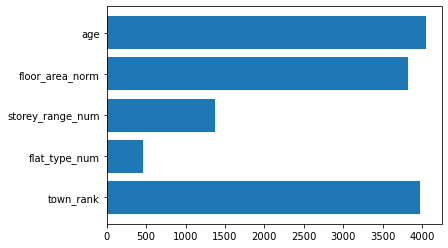

In [52]:
plt.barh(X.columns, model.feature_importances_)
plt.show()

It turns out that the age of the flat, its size and its general area play the largest role in the model's output here. The floor the flat is on surprisingly does not play a large role, especially since many people have the opinion that flats on higher floors should be more expensive. Also, the type of flat surprisingly does not contribute much as well. This might be because the size of the flat is a more important factor than what its type is.

## Part 6 - Future Work

Although we managed to train a relative good predictve model with an R<sup>2</sup> score of more than 0.9 using only a few features, this is certainly not the best model we could have achieved. 

The original data contained temporal shifts in the resale prices of the flats. While the median resale flat prices did not change significantly from the start of 2015 to the end of 2019, from the start of 2020 to the end of 2021, the median prices rose from 400000 SGD to 500000 SGD, representing a 20% increase. Additionally, the long term changes in the resale prices differed according to the town the flat was located in. In order to account for this temporal shift, we trained linear regression models to adjust the older prices to match latest prices.

Additionally, we did not use precise geographical information such as the street name or the address in our model. In particular, if we are able to properly geocode the addresses into geographical coordinates and use those coordinates as the model's input, we might be able to get a model with greater resolution. Unfortunately most geocoders cost either money or have severe limitations which limit their usability. 

Finally, we trained a model using a simple cross validation grid search of the hyperparameters due to a lack of computing resources. Thorough cross validation and hyperparameter optimization will ensure that the model's performance is optimized, and that its outputs are generalizable.

## Data Used

All data used in this notebook can be obtained from: https://data.gov.sg/dataset/resale-flat-prices.